In [1]:
from pathlib import Path

import shutil
import numpy as np
import matplotlib.pyplot as plt

from corems.mass_spectra.input.rawFileReader import ImportMassSpectraThermoMSFileReader
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulasLC
from corems.encapsulation.factory.parameters import LCMSParameters, reset_lcms_parameters, reset_ms_parameters
from corems.mass_spectra.calc.lc_calc import find_closest

# Delete the "Blanch_Nat_Lip_C_12_AB_M_17_NEG_25Jan18_Brandi-WCSH5801.corems" directory
shutil.rmtree(
    "Blanch_Nat_Lip_C_12_AB_M_17_NEG_25Jan18_Brandi-WCSH5801.corems",
    ignore_errors=True,
)

# Instantiate parser based on binary file type
file_raw = (
    Path.cwd()
    / "tests_data/lcms/"
    / "Blanch_Nat_Lip_C_12_AB_M_17_NEG_25Jan18_Brandi-WCSH5801.raw"
)
parser = ImportMassSpectraThermoMSFileReader(file_raw)

# Instatiate lc-ms data object using parser and pull in ms1 spectra into dataframe (without storing as MassSpectrum objects to save memory)
myLCMSobj = parser.get_lcms_obj(spectra="ms1")

# Set parmaeters to the defaults for reproducible testing
myLCMSobj.parameters = LCMSParameters(use_defaults=True)

# Set parameters on the LCMS object that are reasonable for testing
## persistent homology parameters
myLCMSobj.parameters.lc_ms.peak_picking_method = "persistent homology"
myLCMSobj.parameters.lc_ms.ph_inten_min_rel = 0.0005
myLCMSobj.parameters.lc_ms.ph_persis_min_rel = 0.05
myLCMSobj.parameters.lc_ms.ph_smooth_it = 0
myLCMSobj.parameters.lc_ms.ms2_min_fe_score = 0.3
myLCMSobj.parameters.lc_ms.ms1_scans_to_average = 5

## MSParameters for ms1 mass spectra
ms1_params = myLCMSobj.parameters.mass_spectrum['ms1']
ms1_params.mass_spectrum.noise_threshold_method = "relative_abundance"
ms1_params.mass_spectrum.noise_threshold_min_relative_abundance = 0.1
ms1_params.mass_spectrum.noise_min_mz, ms1_params.mass_spectrum.min_picking_mz = 0, 0
ms1_params.mass_spectrum.noise_max_mz, ms1_params.mass_spectrum.max_picking_mz = np.inf, np.inf
ms1_params.ms_peak.legacy_resolving_power = False
ms1_params.molecular_search.url_database = ""
ms1_params.molecular_search.usedAtoms = {
    'C': (10, 30),
    'H': (18, 200),
    'O': (1, 23),
    'N': (0, 3),
    'P': (0, 1),
    'S': (0, 1),
}

## settings for ms2 data (HCD scans)
ms2_params_hcd = ms1_params.copy()
ms2_params_hcd.molecular_search.ion_types_excluded = ["[M+HCOO]-"]
myLCMSobj.parameters.mass_spectrum['ms2'] = ms2_params_hcd

## settings for ms2 data (CID scans)
ms2_params_cid = ms2_params_hcd.copy()
ms2_params_cid.molecular_search.max_ppm_error = 200 # wider ppm error for CID scans
ms2_params_cid.mass_spectrum.noise_threshold_min_relative_abundance = 0.01 # lower noise threshold for CID scans
myLCMSobj.parameters.mass_spectrum['ms2_cid'] = ms2_params_cid

## reporting settings
myLCMSobj.parameters.lc_ms.search_as_lipids = True
myLCMSobj.parameters.lc_ms.include_fragment_types = True
myLCMSobj.parameters.lc_ms.export_eics = True
myLCMSobj.parameters.lc_ms.export_profile_spectra = True

# Use persistent homology to find mass features in the lc-ms data
# Find mass features, cluster, and integrate them.  Then annotate pairs of mass features that are c13 iso pairs.    
myLCMSobj.find_mass_features()
myLCMSobj.add_associated_ms1(
    auto_process=True, use_parser=False, spectrum_mode="profile"
)

myLCMSobj.integrate_mass_features(drop_if_fail=True)
myLCMSobj.deconvolute_ms1_mass_features()

Found 239 initial mass features
131 mass features remaining
131 mass features remaining


In [2]:
## initial data processing
df = myLCMSobj._ms_unprocessed[1].copy()
df = df.dropna(subset=['intensity']).reset_index(drop = True)
threshold = myLCMSobj.parameters.lc_ms.ph_inten_min_rel * df.intensity.max()
df_thres = df[df["intensity"] > threshold].reset_index(drop=True).copy()
df = myLCMSobj.grid_data(df_thres)
df = df.merge(myLCMSobj.scan_df[['scan', 'scan_time']], on = 'scan')

## format unprocessed data
step = 1e-3 ###PARAM
mz_grid = np.arange(0, np.max(df.mz), step)
mz_data = np.array(df.mz)
df['mz_bin'] = find_closest(mz_grid, mz_data)
df['ab_bin'] = df.groupby(['mz_bin', 'scan_time']).intensity.transform(sum)
unproc_df = df[['scan_time', 'mz_bin', 'ab_bin']].drop_duplicates(ignore_index = True)

## format mass feature data
mf_y = []
mf_x = []
for k in myLCMSobj.mass_features.keys(): ## is there a faster way to extract the mass feature data?
    mf_x.append(myLCMSobj.mass_features[k].retention_time)
    mf_y.append(myLCMSobj.mass_features[k].mz)

## format ms2 data
## this processes may need more consideration
ms2_df = myLCMSobj.scan_df[myLCMSobj.scan_df.ms_level == 2]
thresh_y = 0.05 ###PARAM
thresh_x = 0.05 ###PARAM
ms2_x = []
ms2_y = []

for i in range(len(mf_y)): 
    df1 = ms2_df[(ms2_df.precursor_mz <= np.round(mf_y[i], 1) + thresh_y) & (ms2_df.precursor_mz >= np.round(mf_y[i], 1) - thresh_y)]
    df2 = df1[(df1.scan_time <= np.round(mf_x[i], 1) + thresh_x) & (df1.scan_time >= np.round(mf_x[i], 1) - thresh_x)]
    ## with this sample data, len(df2) is only ever 0, 1, or 2
    # if 0, no match and skipped
    # if 2, data is so close together (it's assumed) either location is ok so first is selected due to convenience
    if len(df2) > 0:
        ms2_y.append(df2.precursor_mz.iloc[0])
        ms2_x.append(df2.scan_time.iloc[0])

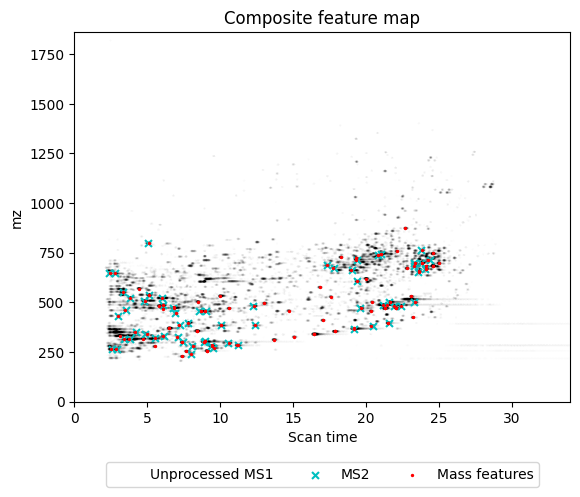

In [7]:
fig = plt.figure()
plt.scatter(
    unproc_df.scan_time,
    unproc_df.mz_bin*step,
    c = unproc_df.ab_bin/np.max(unproc_df.ab_bin),
    alpha = unproc_df.ab_bin/np.max(unproc_df.ab_bin), 
    cmap = 'Greys_r',
    s = 1,
    label = 'Unprocessed MS1' ## the legend here is using cmap == 0 so it's white, would prefer cmap == 1 or 0.5
)

plt.scatter(
    ms2_x,
    ms2_y,
    c = 'c',
    marker = 'x',
    s = 25,
    label = 'MS2'
)

plt.scatter(
    mf_x,
    mf_y,
    c = 'r',
    s = 2,
    label = 'Mass features'
)

plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.25), ncol = 3)
plt.xlabel('Scan time')
plt.ylabel('mz')
plt.ylim(0, np.ceil(np.max(df.mz)))
plt.xlim(0, np.ceil(np.max(df.scan_time)))
plt.title('Composite feature map')
plt.show()